# Определение стоимости автомобилей

**Введение**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель**

Найти модель с наилучшим качеством и скоростью предсказания, и минивальным временем обучения

## Подготовка данных

### Импорты

In [1]:
import pandas as pd
import time
import numpy as np

import warnings
warnings.filterwarnings('ignore')
import pandas_profiling
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

RND = 12345

### Загрузка данных

In [2]:
try:
    df = pd.read_csv('autos.csv')
except: 
    df = pd.read_csv('/datasets/autos.csv')

**Признаки**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**
* `Price` — цена (евро)

### Отчет по данным

In [3]:
profile = ProfileReport(df, title="Определение стоимости автомобилей")

In [4]:
profile.to_file(output_file="autos_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
profile.to_notebook_iframe()

**вот скриншот из получившегося профайла** *сам отчет в pdf и html в папке проекта*

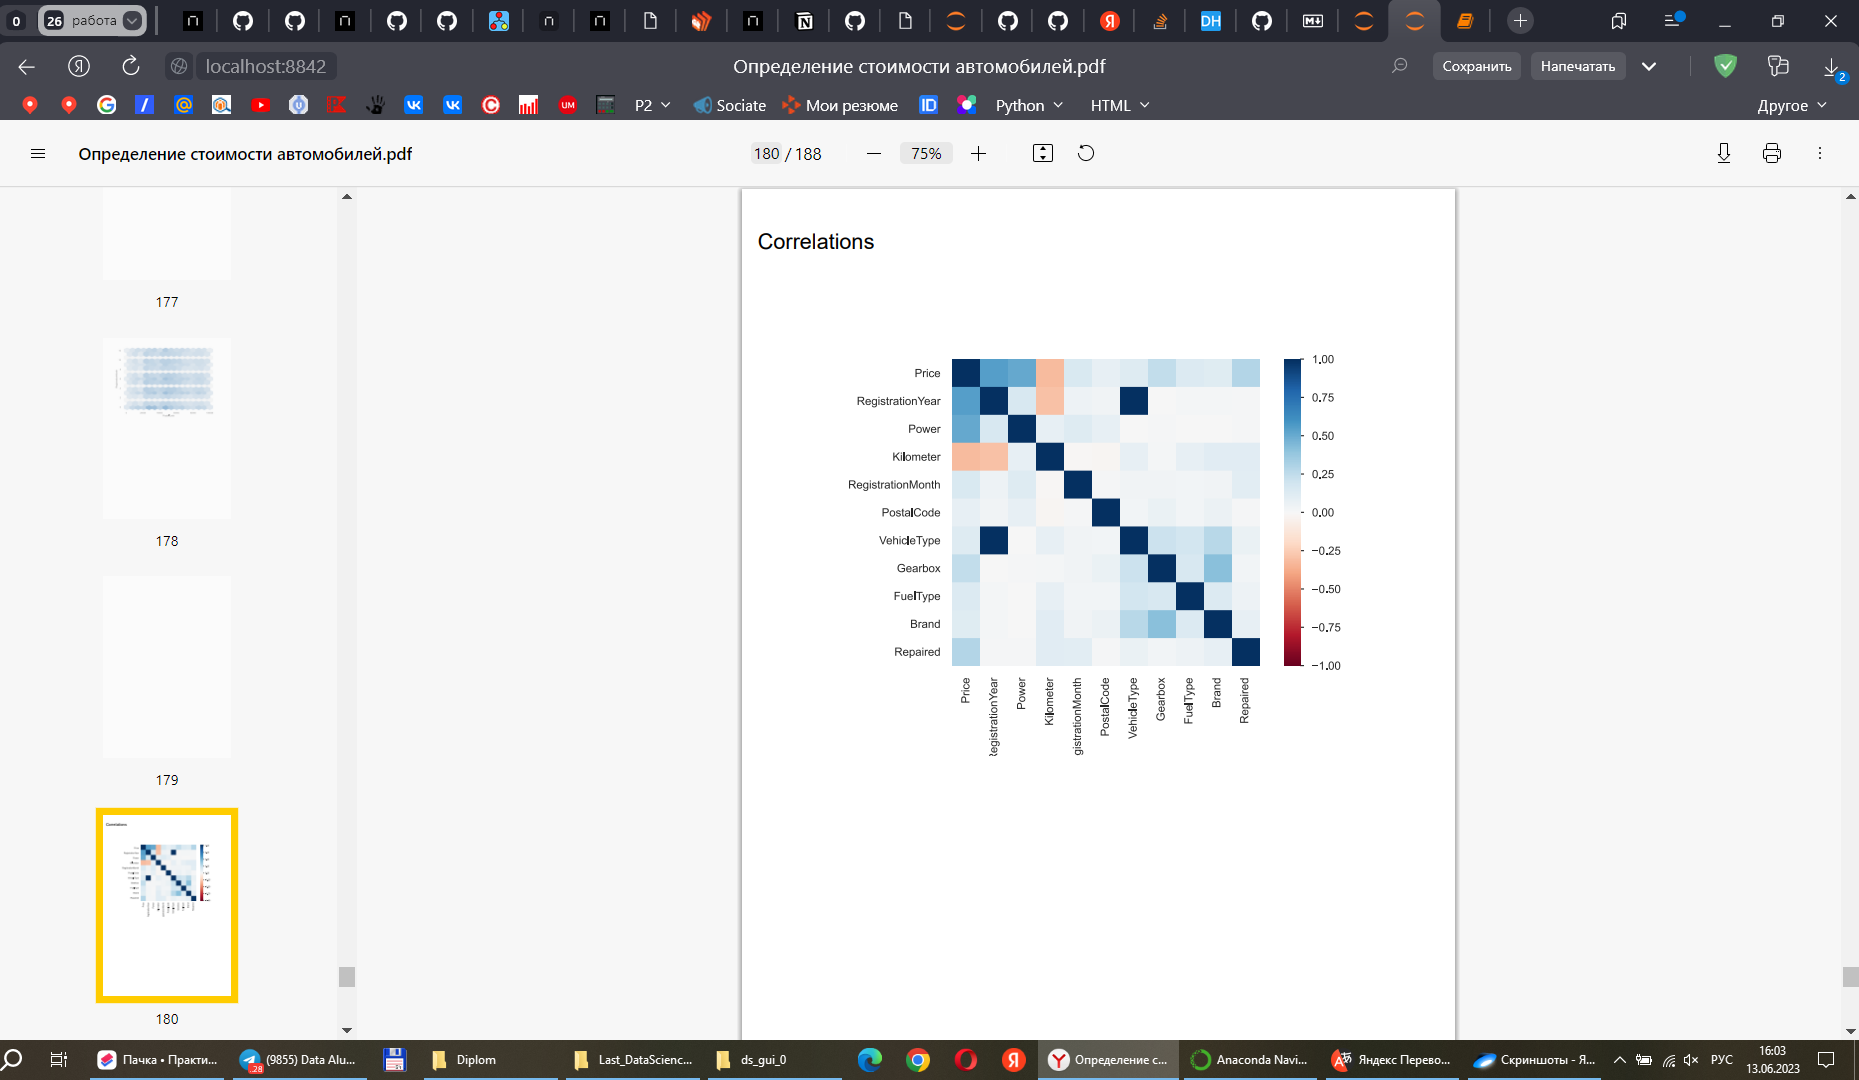

#### Вывод по отчету

**Корреляция к целевому признаку**<br>
* `RegistrationYear` — год регистрации автомобиля - **0,551**
* `Power` — мощность (л. с.) - **0,513**
* `Repaired` — была машина в ремонте или нет - **0,292**
* `Gearbox` — тип коробки передач - **0,248**
* `Kilometer` — пробег (км) - тут отрицательна корреляция, что вполне естественно **-0,314**


**Проблемные данные:**<br>

**Надено 4 дубликата**<br>

**Обнаружены пропуски**
* `VehicleType` — тип автомобильного кузова - **37490**
* `Gearbox` — тип коробки передач - **19833**
* `Model` — модель автомобиля - **19705**
* `FuelType` — тип топлива - **32895**
* `Repaired` — была машина в ремонте или нет - **71154**

**Нулевые значения**
* `Price` — цена (евро) - **10772 (3.0%)**
* `Power` — мощность (л. с.) - **40225 (11.4%)**
* `RegistrationMonth` — месяц регистрации автомобиля - **37352 (10.5%)**

**Аномалии**
* `RegistrationYear` — год регистрации автомобиля - **коэффициент асимметрии (γ1 = 74.62100514)**
* `Power` — мощность (л. с.) - **коэффициент асимметрии (γ1 = 60.15719573)**

### Дубликаты

Их всего 4 можно просто удалить

In [6]:
df = df.drop_duplicates().reset_index(drop=True)
print('Теперь дубликатов:', df.duplicated ().sum())

Теперь дубликатов: 0


### Нулевые значения и аномалии

**Нулевые значения**
* `Price` — цена (евро) - **10772 (3.0%)**
* `Power` — мощность (л. с.) - **40225 (11.4%)**
* `RegistrationMonth` — месяц регистрации автомобиля - **37352 (10.5%)**

**Аномалии**
* `RegistrationYear` — год регистрации автомобиля - **коэффициент асимметрии (γ1 = 74.62100514)**
* `Power` — мощность (л. с.) - **коэффициент асимметрии (γ1 = 60.15719573)**

#### Price

Нулевые значения - **10772 (3.0%)** скорее всего это уже объявления по уже проданным машинам, просто их не сняли с публикации.<br>
Удаляем.

In [7]:
df = df[df['Price'] > 0]
df = df.reset_index(drop=True)
print('Нулевых значений:', df[df['Price'] == 0].shape[0])

Нулевых значений: 0


**Так же сдесь есть слишком низкие цены**<br>
цены менее 50 похожи на выбросы или ошибки ввода

In [8]:
print('Цены менее 50 составляют:',(round((df[df['Price'] < 50]['Price']
                                          .shape[0] / df.shape[0] * 100), 2)),'%')

Цены менее 50 составляют: 0.48 %


Удаляем их

In [9]:
df = df[df['Price'] > 50]
df = df.reset_index(drop=True)
print('Цены менее 50 составляют:',(round((df[df['Price'] < 50]['Price']
                                          .shape[0] / df.shape[0] * 100), 2)),'%')

Цены менее 50 составляют: 0.0 %


#### Power — мощность (л. с.)

Нулевой мощьности было (11.4%) <br>
Так же, были анамалии.

In [10]:
print('Теперь нулевых осталось', round((df[df['Power'] == 0]['Power'].shape[0] / df.shape[0] * 100), 2), '%')
print('слабее запорожца (40 л/с):', round((df[df['Power'] < 40]['Power'].shape[0] / df.shape[0] * 100 - 10.35), 2), '%')
print('круче феррари (720 л/с):', round((df[df['Power'] > 720]['Power'].shape[0] / df.shape[0] * 100), 2), '%')

Теперь нулевых осталось 10.35 %
слабее запорожца (40 л/с): 0.39 %
круче феррари (720 л/с): 0.09 %


Как либо восстановить эти значения даже зная модель автомобиля не возможно, т.к. возможно машина подвергалась доработкам.<br> 
Заглушки ставить тоже не стоит - этот параметр коррелирует с целевым и это может сказаться на качестве обучения.<br>
Разумнее всего удалить.

In [11]:
df = df[(df['Power'] > 40) & (df['Power'] <= 720)]

#### RegistrationMonth — месяц регистрации автомобиля

In [12]:
print('В начале было 10.5% нулевых месяцов, на данный момент их:',
      round((df[df['RegistrationMonth'] == 0]['RegistrationMonth']
                                         .shape[0] / df.shape[0] * 100), 2), '%')

В начале было 10.5% нулевых месяцов, на данный момент их: 6.43 %


Эти данные следует удалить.

In [13]:
df = df[df['RegistrationMonth'] > 0]

In [14]:
df['RegistrationMonth'].describe()

count    284717.000000
mean          6.382338
std           3.347052
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

#### RegistrationYear — год регистрации автомобиля

В этом параметре были обнаружены анамалии

In [15]:
df[(df['RegistrationYear'] < 1900) | (df['RegistrationYear'] > 2019)]

DateCrawled  Price VehicleType  RegistrationYear Gearbox  \
17569   2016-03-09 17:49:44   7999         NaN              1500  manual   
45074   2016-03-12 07:36:23   5000         NaN              2900  manual   
77027   2016-03-20 18:56:44   9000         NaN              5000  manual   
210296  2016-03-16 12:46:55   7999         NaN              1800     NaN   
246613  2016-03-31 22:49:04   1700         NaN              2800  manual   
308916  2016-03-16 07:54:37    500         NaN              8200    auto   
310638  2016-03-24 17:56:29  15000         NaN              5000     NaN   

        Power    Model  Kilometer  RegistrationMonth FuelType       Brand  \
17569     224  impreza       5000                  3      NaN      subaru   
45074     120    corsa       5000                  9   petrol        opel   
77027     420  impreza       5000                  6   petrol      subaru   
210296    290     golf       5000                  6      NaN  volkswagen   
246613     98      NaN       5000                  7   petrol  volkswagen   
308916     81  octavia      10000                 11      NaN       skoda   
310638    155     golf       5000                  5   petrol  volkswagen   

       Repaired          DateCreated  NumberOfPictures  PostalCode  \
17569       NaN  2016-03-09 00:00:00                 0       53577   
45074       NaN  2016-03-12 00:00:00                 0        9326   
77027        no  2016-03-20 00:00:00                 0       34253   
210296      NaN  2016-03-16 00:00:00                 0       15827   
246613      NaN  2016-03-31 00:00:00                 0       83022   
308916      NaN  2016-03-16 00:00:00                 0       30559   
310638      NaN  2016-03-24 00:00:00                 0       38302   

                   LastSeen  
17569   2016-03-15 05:15:17  
45074   2016-04-05 23:18:26  
77027   2016-04-07 02:45:30  
210296  2016-03-29 20:47:40  
246613  2016-03-31 23:44:01  
308916  2016-03-16 08:52:33  
310638  2016-04-07 11:16:25

Этих записей всего 7. **Удаляем**

In [16]:
df = df[(df['RegistrationYear'] > 1900) & (df['RegistrationYear'] < 2019)]

### Пропуски

* `VehicleType` — тип автомобильного кузова - **37490**
* `Gearbox` — тип коробки передач - **19833**
* `Model` — модель автомобиля - **19705**
* `FuelType` — тип топлива - **32895**
* `Repaired` — была машина в ремонте или нет - **71154**

In [17]:
pd.concat([df.isna().sum().sort_values(ascending=False),
           (df.isna().mean()*100).sort_values(ascending=False)],
          axis=1, keys=['Всего', 'В процентах']).style.background_gradient('coolwarm')

#### VehicleType — тип автомобильного кузова

Не смотря на то, что среди типов, есть тип other, не ястно что под этим имелось ввиду. Придется ставить заглушку.

In [19]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')

#### Gearbox — тип коробки передач 

<AxesSubplot:>

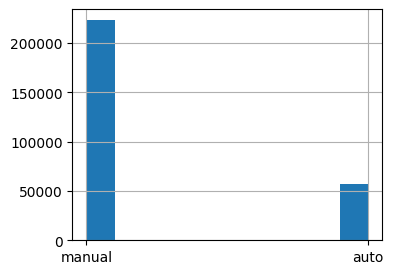

In [20]:
df['Gearbox'].hist(figsize=(4, 3))

Преобладает механика. Меняем пропуски на механнику

In [21]:
df['Gearbox'] = df['Gearbox'].fillna('manual')

In [22]:
df['Gearbox'].unique()

array(['manual', 'auto'], dtype=object)

#### Model — модель автомобиля

По имеющимся данным не возможно точно определить модель. Ставим заглушку.

In [23]:
df['Model'] = df['Model'].fillna('unknown')

#### FuelType — тип топлива

<AxesSubplot:>

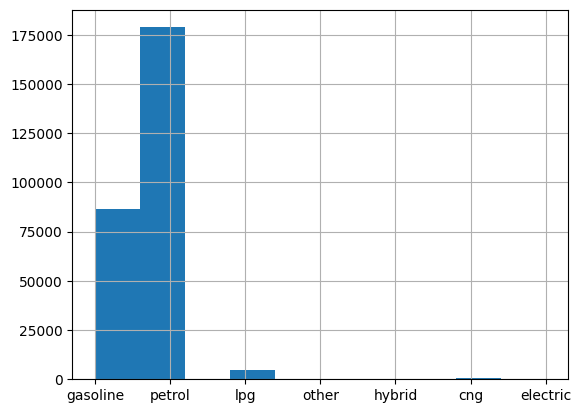

In [24]:
df['FuelType'].hist()

1.LNG (Liquified Natural Gas) – сжиженный природный газ. Получают при охлаждении природного газа до температуры –160°C. При этом происходит сжатие газа по объему в 600 раз, а его вес уменьшается вдвое по сравнению с газообразным состоянием.

2.CNG (Compressed Natural Gas) – сжатый природный газ (метан): газообразные углеводороды, образующиеся в земной коре, высокоэкономичное энергетическое топливо.

3.LPG (Liquified Petroleum Gas) – сжиженный газ (пропан-бутан). Газ, полученный при добыче и переработке нефти. В жидкое состояние переводят при охлаждении до критической температуры и последующей конденсации в результате отвода теплоты парообразования.

4.SNG (Synthetic natural gas) – синтезированный природный газ (СПГ): газ, полученный из угля или нефти, состоит из тех же основных химических элементов, что и природный газ, и имеет такие же горючие свойства.

В автомобилях применяют пп. 2-3.<br>
Так что можно считать что с трехбуквенными названиями топлева у нас все хорошо.

petrol и gasoline - это бензин.<br>
В Америке распространено gasoline, а в Англии petrol.<br>
Правильнее заменить, на что-нибудь одно, например petrol.<br>
На этоже значение стоит заменить и все пропуски, как на наиболее преобладающее.

In [25]:
df['FuelType'] = df['FuelType'].fillna('petrol')
df.loc[df['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

In [26]:
df['FuelType'].unique()

array(['petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

#### Repaired — была машина в ремонте или нет

Былали машина в ремонте не возможно определить ни по каким признакам. Ставим заглушку.

In [27]:
df['Repaired'] = df['Repaired'].fillna('unknown')

In [28]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

#### Удаление признаков не влияющих на обучение

* `DateCrawled` — дата скачивания анкеты из базы
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля **(их вообще всегда 0)**
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

In [29]:
df.drop(columns = ['DateCrawled', 'DateCreated', 'NumberOfPictures',
                   'PostalCode', 'LastSeen'], inplace=True)

In [30]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

### Разделение на train и test

<AxesSubplot:title={'center':'соотношение 75/25'}, ylabel='разделение датафрейма'>

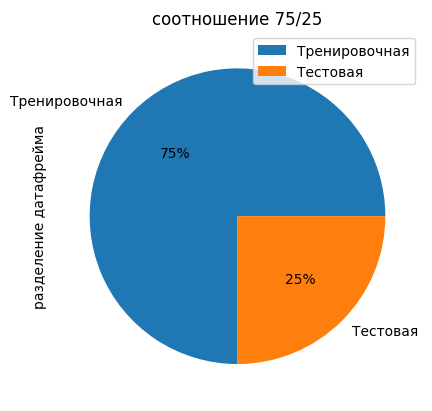

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.25, random_state=RND)
data_separation = pd.DataFrame({'name': ['Тренировочная',
                                         'Тестовая'],
                                'разделение датафрейма': [
                                    X_train.shape[0],
                                    X_test.shape[0]]})
data_separation = data_separation.set_index('name')
data_separation.plot(kind='pie', y='разделение датафрейма', autopct='%1.0f%%', title='соотношение 75/25')

**Список категорийных признаков**

In [32]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

<a name="1"></a>

## Обучение моделей 

In [68]:
time_fit =[] # это для времени обучения
time_prediction = [] # Это для времени предсказания
RMSE_model = [] # RMSE модели
name_model = [] # название модели

### CatBoostRegressor

In [51]:
%%time

model = CatBoostRegressor(iterations=10, 
                          verbose=False,
                          cat_features=cat_features,
                          random_seed=RND)

params = {'depth': range(2, 10, 2)}

grid = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train) 

print('Лучшие параметры:', grid.best_params_)

Лучшие параметры: {'depth': 8}
CPU times: total: 15.1 s
Wall time: 42.9 s


**Теперь, модель по этим параметрам**

In [69]:
%%time
name_model.append('CatBoostRegressor grid')
start = time.time()

model = CatBoostRegressor(eval_metric='RMSE', 
                          iterations=8,
                          verbose=False,
                          use_best_model=False,
                          random_seed=RND)

model.fit(X_train, y_train, cat_features=cat_features)

stop = time.time()
time_fit.append(time.time() - start)

CPU times: total: 4.09 s
Wall time: 1.67 s


In [70]:
%%time
start = time.time()

predicted = model.predict(X_train)

stop = time.time()
time_prediction.append(time.time() - start)
rmse = mean_squared_error(y_train, model.predict(X_train), squared=False)
RMSE_model.append(rmse)
print('RMSE:', rmse)

RMSE: 1996.0054155223218
CPU times: total: 1.17 s
Wall time: 1.03 s


### LightGBM

**Кодируем категориальные признаки**

In [72]:
encoder = LabelEncoder()
X1_train = X_train.copy()
X1_test = X_test.copy()

for _ in cat_features:
    X1_train[_] = encoder.fit_transform(X1_train[_])
    X1_test[_] = encoder.fit_transform(X1_test[_])

**С начала попробуем с параметрами по умолчанию**

In [73]:
%%time
name_model.append('LGBMRegressor base')
start = time.time()

model = LGBMRegressor(num_leaves= 31, learning_rate=0.01,
                      max_depth=-1, n_estimators=250, random_state=RND)
model.fit(X1_train, y_train, categorical_feature=cat_features)

time_fit.append(time.time() - start)

CPU times: total: 17.6 s
Wall time: 5.37 s


In [74]:
%%time
start = time.time()

predicted = model.predict(X1_train)

time_prediction.append(time.time() - start)
rmse = mean_squared_error(y_train, model.predict(X1_train), squared=False)
RMSE_model.append(rmse)
print('RMSE:', rmse)

RMSE: 1851.4361599627018
CPU times: total: 14.8 s
Wall time: 3.86 s


**Теперь попробуем поиск по сетке**

In [75]:
%%time

model = LGBMRegressor(random_state=RND)
params = {'n_estimators': np.arange(50, 300, 50),
          'num_leaves': [31, 51],
          'max_depth': np.arange(1, 41, 10)
}

grid =  GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', verbose=True)
grid.fit(X1_train, y_train)

print('Лучшие параметры по сетке:', grid.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Лучшие параметры по сетке: {'max_depth': 21, 'n_estimators': 250, 'num_leaves': 51}
CPU times: total: 25min 27s
Wall time: 7min 39s


**Теперь создадим модель с этими параметрами**

In [76]:
%%time
name_model.append('LGBMRegressor grid')
start = time.time()

model = LGBMRegressor(num_leaves= 51, 
                      learning_rate=0.01,
                      max_depth=21, 
                      n_estimators=250, 
                      random_state=RND)
model.fit(X1_train, y_train, categorical_feature=cat_features)

time_fit.append(time.time() - start)

CPU times: total: 21.6 s
Wall time: 6.09 s


In [77]:
%%time
start = time.time()

predicted = model.predict(X1_train)

time_prediction.append(time.time() - start)
rmse = mean_squared_error(y_train, model.predict(X1_train), squared=False)
RMSE_model.append(rmse)
print('RMSE:', rmse)

RMSE: 1790.6207364329819
CPU times: total: 17.3 s
Wall time: 4.53 s


### DecisionTreeRegressor

In [78]:
%%time

model = DecisionTreeRegressor(random_state = RND)

param = {'max_depth':range (1, 30)
        #'random_state': RND
        }

grid = GridSearchCV(model, param, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid.fit(X1_train, y_train)

print('Лучшие параметры по сетке:', grid.best_params_)

Лучшие параметры по сетке: {'max_depth': 13}
CPU times: total: 3.55 s
Wall time: 1min 13s


**Теперь модель дерева по этим параметрам**

In [79]:
%%time

name_model.append('DecisionTreeRegressor')
start = time.time()

model = DecisionTreeRegressor(max_depth=13, random_state=RND)
model.fit(X1_train, y_train) 

time_fit.append(time.time() - start)

CPU times: total: 797 ms
Wall time: 794 ms


In [80]:
%%time

start = time.time()

predictions = model.predict(X1_train)

time_prediction.append(time.time() - start)
rmse = mean_squared_error(y_train, model.predict(X1_train), squared=False)
RMSE_model.append(rmse)
print('RMSE:', rmse)

RMSE: 1594.7337335055206
CPU times: total: 172 ms
Wall time: 156 ms


### LinearRegression

In [81]:
%%time

start = time.time()
name_model.append('LinearRegression')

model = LinearRegression().fit(X1_train, y_train)

time_fit.append(time.time() - start)

CPU times: total: 141 ms
Wall time: 130 ms


In [82]:
%%time
start = time.time()

predictions = model.predict(X1_train)

time_prediction.append(time.time() - start)
rmse = mean_squared_error(y_train, model.predict(X1_train), squared=False)
RMSE_model.append(rmse)
print('RMSE:', rmse)

RMSE: 3028.783697451512
CPU times: total: 109 ms
Wall time: 107 ms


## Анализ моделей

In [83]:
results = {
    'Model' : pd.Series(name_model),
    'Time fit': pd.Series(time_fit),
    'Time prediction': pd.Series(time_prediction),
    'RMSE' :pd.Series(RMSE_model),
    }
results = pd.DataFrame(results)
results = results.set_index('Model')
results = results.sort_values('RMSE')
display(results)

Time fit  Time prediction         RMSE
Model                                                         
DecisionTreeRegressor   0.794045         0.088058  1594.733734
LGBMRegressor grid      6.090483         2.347276  1790.620736
LGBMRegressor base      5.373977         1.941805  1851.436160
CatBoostRegressor grid  1.673378         0.466308  1996.005416
LinearRegression        0.129864         0.056036  3028.783697

<AxesSubplot:xlabel='Model'>

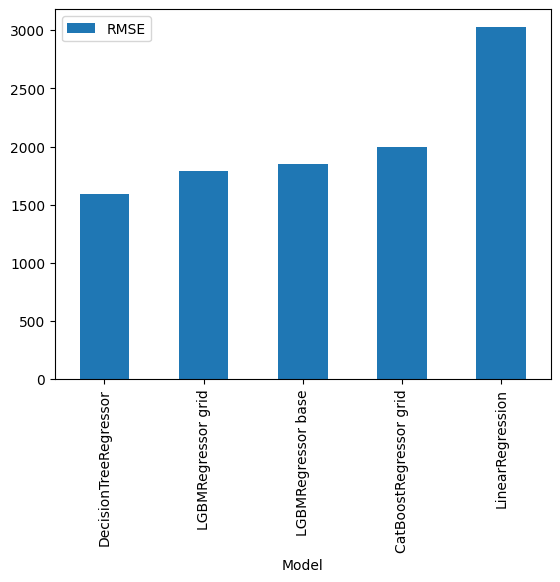

In [84]:
results['RMSE'].plot(kind='bar', legend=True)

<a name="3"></a>

### Вывод по обучению на тренировочных данных

Был проведен анализ предоставленного датасета и подготовка данных к дальнейшему обучению<br>
Проведено обучение моделей:
* CatBoostRegressor
* LGBMRegressor
* DecisionTreeRegressor
* LinearRegression	

DecisionTreeRegressor	0.794045	0.088058	1594.733734
LGBMRegressor grid	6.090483	2.347276	1790.620736
LGBMRegressor base	5.373977	1.941805	1851.436160
CatBoostRegressor grid	1.673378	0.466308	1996.005416
LinearRegression	0.129864	0.056036	3028.783697

На тренировачных данных наилучшие результаты достигнуты на модели `DecisionTreeRegressor` с `max_depth = 13`, `RMSE` составила `1594`, время обучения `0.79` и время предсказания `0.08`. Эта модель лучшая по параметрам `RMSE` и скорости обучения и предсказания. Ближайшая модель LGBMRegressor с результатами полученными по сетке. Это `1790` для `RMSE` и `6.09` на `2.34` временем обучения и предсказания соответственно.


**Осталось протестировать модели с лучшеми показателями**<a name="4"></a>

## Тестирование лучшей модели

### Тест DecisionTreeRegressor с параметрами по сетке

In [88]:
%%time
start = time.time()

dt_model = DecisionTreeRegressor(max_depth=13, 
                              random_state=RND)
dt_model.fit(X1_train, y_train) 

print(time.time() - start)

1.0147786140441895
CPU times: total: 1 s
Wall time: 1.01 s


In [91]:
%%time
start = time.time()

predictions = dt_model.predict(X1_test)

print('Время предсказания по тестовым данным', time.time() - start)
rmse = mean_squared_error(y_test, dt_model.predict(X1_test), squared=False)
RMSE_model.append(rmse)
print('RMSE:', rmse)
print('*'*30)

Время предсказания по тестовым данным 0.031018495559692383
RMSE: 1954.0291426340514
******************************
CPU times: total: 62.5 ms
Wall time: 61 ms


DecisionTreeRegressor	0.794045	0.088058	1594.733734
LGBMRegressor grid	6.090483	2.347276	1790.620736

### Тест LGBMRegressor grid	(на всякий случай) с параметрами по сетке

In [95]:
%%time
start = time.time()

lgbm_model = LGBMRegressor(num_leaves= 51, 
                      learning_rate=0.01,
                      max_depth=21, 
                      n_estimators=250, 
                      random_state=RND)
lgbm_model.fit(X1_train, y_train, categorical_feature=cat_features)

print(time.time() - start)

7.115283966064453
CPU times: total: 20.8 s
Wall time: 7.12 s


In [94]:
%%time
start = time.time()

predicted = lgbm_model.predict(X1_test)

print('Время предсказания по тестовым данным', time.time() - start)
rmse = mean_squared_error(y_test, lgbm_model.predict(X1_test), squared=False)
RMSE_model.append(rmse)
print('RMSE:', rmse)
print('*'*30)

Время предсказания по тестовым данным 0.786386251449585
RMSE: 2078.3640108160107
******************************
CPU times: total: 6.09 s
Wall time: 1.68 s


<a name="5"></a>

### Вывод

На тестовых даннйх проверены модели `LGBMRegressor` с данными полученными по сетке и `DecisionTreeRegressor`.<br>
Целью этой работы было подобрать параметры для модел с `RMSE` меньше `2500`. <br>

С этой задачей справились обе модели.<br>
**DecisionTreeRegressor**
* Время предсказания: 0.031
* RMSE: 1954

**LGBMRegressor** 
* Время предсказания: 0.78
* RMSE: 2078

Наиболее эффективной является модель случайного дерева. У нее лучшие показатели по RMSE и времени.<br>
Таким образом модель `DecisionTreeRegressor` с глубиной в 3 рекомендуется для дальнейшего использования.